In [1]:
#dataframes
import pandas as pd
import h5py

import sys
sys.path.append('../')
import odor_statistics_lib as osm

# user defined functions

#speedup
import multiprocessing as mp

#suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.TimeSeries = pd.Series 

#math
import numpy as np
import math
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import signal
import scipy 
import scipy.stats as st
from scipy.stats import kurtosis

#plots
import pylab as plt
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import matplotlib
from figurefirst import FigureLayout,mpl_functions
import figurefirst
import matplotlib.image as mpimg
from mpl_toolkits.axes_grid1 import make_axes_locatable # for colorbar
import seaborn as sns
sns.set()
sns.set_style("whitegrid")
import figurefirst as fifi
from IPython.display import display,SVG

import networkx as nx
import community.community_louvain as community_louvain # pip install community

#misc
import cairosvg
import time
np.set_printoptions(suppress=True)
import fly_plot_lib.plot as fpl
# matplotlib.rcParams['font.family'] = [ 'sans-serif']
FS=7

In [2]:
dir = '~/DataAnalysis/data/Sprints/HighRes/LouvainAnalysis'
dataframe=pd.read_hdf(dir+'/DesertPrediction.h5')

In [3]:
# Helper function
def calculate_louvain_communities(assignment_matrix, node_order=None):
    # Calculate louvain communities
    G = nx.to_networkx_graph(assignment_matrix, create_using=nx.Graph())  
    louvain_community_dict = community_louvain.best_partition(G)
    # Convert community assignmet dict into list of communities
    louvain_comms = {}
    for node_index, comm_id in louvain_community_dict.items():
        if comm_id in louvain_comms.keys():
            louvain_comms[comm_id].append(node_index)
        else:
            louvain_comms.setdefault(comm_id, [node_index])
    nodes_louvain_ordered = [node for comm in louvain_comms.values() for node in comm]
    # reorder original matrix according to node order
    adjacency_matrix = np.zeros_like(assignment_matrix)
    for i in range(assignment_matrix.shape[0]):
        for j in range(assignment_matrix.shape[0]):
            r = nodes_louvain_ordered.index(i)
            c = nodes_louvain_ordered.index(j)
            adjacency_matrix[r,c] = assignment_matrix[i,j] 
    return G, louvain_community_dict, nodes_louvain_ordered, adjacency_matrix

X=[dataframe.mc_min, dataframe.mc_max, dataframe.mc_mean, dataframe.mc_std_dev, dataframe.mc_k,
   dataframe.wf_min, dataframe.wf_max, dataframe.wf_mean, dataframe.wf_std_dev, dataframe.wf_k,
   dataframe.wd_min, dataframe.wd_max, dataframe.wd_mean, dataframe.wd_std_dev, dataframe.wd_k,
   dataframe.ma_min, dataframe.ma_max, dataframe.ma_mean, dataframe.ma_std_dev, dataframe.ma_k,
   dataframe.st_min, dataframe.st_max, dataframe.st_mean, dataframe.st_std_dev, dataframe.st_k]

REMOVE_Y_CORR = False
y=dataframe.distance

In [4]:
corr_mat = np.zeros([len(X), len(X)])
for i in range(len(X)):
    for j in range(len(X)):
        
        if not REMOVE_Y_CORR:
            result = scipy.stats.linregress(X[i], X[j])
        else:
            result_iy = scipy.stats.linregress(y, X[i])
            resid_i = X[i] - (y*result_iy.slope + result_iy.intercept)

            result_jy = scipy.stats.linregress(y, X[j])
            resid_j = X[j] - (y*result_jy.slope + result_jy.intercept)
            
            result = scipy.stats.linregress(resid_i, resid_j)
            
        corr_mat[i,j] = result.rvalue**2
        
G, louvain_community_dict, nodes_louvain_ordered, adjacency_matrix = calculate_louvain_communities(corr_mat)

In [5]:
n = []
for i in range(len(X)):
    n.append(X[i].name)

dicts = {}
keys = range(len(X))
values = n
for i in keys:
        dicts[i] = values[i]
        
new_list_label = sorted(dicts.items(), key=lambda pair: nodes_louvain_ordered.index(pair[0]))

new_list = []
for i in range(len(new_list_label)):
    new_list.append(new_list_label[i][1])
new_list.insert(0, 0)    

In [6]:
print(new_list)

[0, 'mc_min', 'mc_mean', 'wd_min', 'wd_mean', 'st_min', 'st_mean', 'mc_max', 'mc_std_dev', 'st_max', 'st_std_dev', 'mc_k', 'wf_k', 'wd_k', 'ma_k', 'st_k', 'wf_min', 'ma_min', 'wf_max', 'wf_mean', 'wf_std_dev', 'wd_max', 'wd_std_dev', 'ma_max', 'ma_mean', 'ma_std_dev']


In [7]:
## Create latex labels for final plots - manually from new list
label=['$min(WC)$','$\mu(WC)$','$min(WD)$', '$\mu(WD)$',
       '$min(WSD)$','$\mu(WSD)$','$max(WC)$','$\sigma(WC)$', '$max(WSD)$',
       '$\sigma(WSD)$','$WC_k$','$WF_k$','$WD_k$', '$WMA_k$','$WSD_k$',
       '$min(WF)$','$max(WF)$', '$\mu(WF)$','$\sigma(WF)$','$max(WD)$',
       '$\sigma(WD)$','$max(WMA)$', '$\mu(WMA)$','$\sigma(WMA)$','$min(WMA)$']

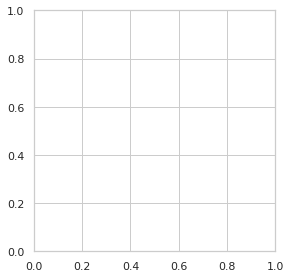

In [10]:
layout = fifi.svg_to_axes.FigureLayout('../../../Figure/louvain.svg',
                                           autogenlayers=True, make_mplfigures=True, hide_layers=[])

In [11]:
ax=layout.axes[('fig1','ax')]
ax.imshow(adjacency_matrix,cmap='bone_r',  aspect='auto',rasterized=True)


ax.grid(False)
# ax.set_title('')louvain

ax.set_rasterization_zorder(-20)

marker = np.arange(0,25,1)
mpl_functions.adjust_spines(ax,['left','bottom'],
                            spine_locations={'left':4,'bottom':4},
                            smart_bounds=True,
                            yticks=marker.tolist(),
                            xticks=marker.tolist(),
                            linewidth=0.5)
ax.set_xticklabels(label, rotation=90)
ax.set_yticklabels(label, rotation=0)



[Text(0, 0, '$min(WC)$'),
 Text(0, 1, '$\\mu(WC)$'),
 Text(0, 2, '$min(WD)$'),
 Text(0, 3, '$\\mu(WD)$'),
 Text(0, 4, '$min(WSD)$'),
 Text(0, 5, '$\\mu(WSD)$'),
 Text(0, 6, '$max(WC)$'),
 Text(0, 7, '$\\sigma(WC)$'),
 Text(0, 8, '$max(WSD)$'),
 Text(0, 9, '$\\sigma(WSD)$'),
 Text(0, 10, '$WC_k$'),
 Text(0, 11, '$WF_k$'),
 Text(0, 12, '$WD_k$'),
 Text(0, 13, '$WMA_k$'),
 Text(0, 14, '$WSD_k$'),
 Text(0, 15, '$min(WF)$'),
 Text(0, 16, '$max(WF)$'),
 Text(0, 17, '$\\mu(WF)$'),
 Text(0, 18, '$\\sigma(WF)$'),
 Text(0, 19, '$max(WD)$'),
 Text(0, 20, '$\\sigma(WD)$'),
 Text(0, 21, '$max(WMA)$'),
 Text(0, 22, '$\\mu(WMA)$'),
 Text(0, 23, '$\\sigma(WMA)$'),
 Text(0, 24, '$min(WMA)$')]

In [12]:
ax.get_xticklabels()[1].set_bbox(dict(facecolor="gray", alpha=0.5))
ax.get_xticklabels()[20].set_bbox(dict(facecolor="gray", alpha=0.5))
ax.get_xticklabels()[21].set_bbox(dict(facecolor="gray", alpha=0.5))
ax.get_xticklabels()[23].set_bbox(dict(facecolor="gray", alpha=0.5))


ax.get_yticklabels()[1].set_bbox(dict(facecolor="gray", alpha=0.5))
ax.get_yticklabels()[20].set_bbox(dict(facecolor="gray", alpha=0.5))
ax.get_yticklabels()[21].set_bbox(dict(facecolor="gray", alpha=0.5))
ax.get_yticklabels()[23].set_bbox(dict(facecolor="gray", alpha=0.5))

In [13]:
figurefirst.mpl_functions.set_fontsize(ax, FS)
layout.append_figure_to_layer(layout.figures['fig1'], 'fig1', cleartarget=True)
layout.write_svg('../../../Figure/louvain.svg')